In [1]:
import clean_data_svi as cds
import supervised as sup
import itertools
import pathlib
import matplotlib.pyplot as plt
import keras_model as km
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from datetime import timedelta, datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K, Sequential, Input, Model
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, LSTM, Bidirectional, Conv1D, MaxPooling1D, MaxPooling2D, Flatten, \
    TimeDistributed, RepeatVector, Dropout, GRU, AveragePooling1D
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, median_absolute_error, roc_curve, auc, f1_score, \
    precision_recall_curve, r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay
import imblearn
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE

Using TensorFlow backend.


In [2]:
#useful functions

In [3]:
def threshold_for_max_f1(y_real, Yhat):
    '''
    Given inputs y_real and y_predict, the function returns
    the threshold (rounded to the nearest hundredth) that
    maximizes f1.
    
    Note: this func not necessarily optimized, could return to 
    doing this but not needed).
    
    Also note that we calculate f1 without using the results method
    in keras_model. This is because we need to check beforehand that
    computing f1 won't produce a NaN so we won't get an invalid value warning.
    '''
    
    #error is occuring in km.results when computing f1, because TNR, NPV are 0, implying that there
    #are no true negatives. While we added if statements to account for at least one predicted
    #negative, this does not correlate to at least one true negative. Hence, instead of using keras.results
    #we use that code by check that tn is not 0
    f1_vals = []
    for i in range(0, 100):
        threshold = i/100
        y_predict = np.where(Yhat > threshold, 1, 0).astype(int)

        cm = confusion_matrix(y_real, y_predict)
        tn, fp, fn, tp = confusion_matrix(y_real, y_predict).ravel()
        
        if tn != 0:      
            TNR = (tn) / (tn + fp)
            NPV = (tn) / (tn + fn)
            f1 = 2 * (TNR * NPV) / (TNR + NPV)
        else:
            f1 = -2   
        f1_vals.append(f1)
        
    f1_vals = np.array(f1_vals)
    f1_vals = np.nan_to_num(f1_vals, nan=-1)
    return (np.argmax(f1_vals))/100

In [4]:
def plot_cf_matrix(y_real, y_predict):
    '''
    Given y_real and y_predict, this method displays the results
    (accuracy, recall, precision, f1) followed by the plot of the confusion matrix.
    '''
    print('results:', km.results(y_real, y_predict), '\n')
    
    classes = ['High_svi', 'Low_svi']
    cm = confusion_matrix(y_real, y_predict)
    disp = sup.plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)
    plt.show(disp)

In [17]:
def over_sample(X, Y, sampler):
    '''
    This function over samples data X and labels Y. Because each piece of data is 2D (hence X is 3D),
    we need to do some clever resizing since the imblearn Oversampling functions only work with a 2D X.
    '''
    
    sampler = sampler(random_state=0)

    orig_X_shape = X.shape
    X_reshaped = np.reshape(X, (X.shape[0], X.shape[1]*X.shape[2]))
    X_resampled, Y_resampled = sampler.fit_resample(X_reshaped, Y)
    X_resampled = np.reshape(X_resampled, (X_resampled.shape[0], orig_X_shape[1], orig_X_shape[2]))
    
    return X_resampled, Y_resampled

In [5]:
#compiling data

In [6]:
SVI_list = []
for i in range(4):
    df = pd.read_csv(f"clean_tables/svi_{i+1}.csv", index_col="date")
    df = df.drop(columns=['Settling_velocity', 'SV_label', 'SVI_label'])
    df.index = pd.to_datetime(df.index, dayfirst=True)
    SVI_list.append(df)

In [7]:
temp_df = pd.read_csv("clean_tables/temperatur.csv", index_col="date")
temp_df.index = pd.to_datetime(temp_df.index, dayfirst=True)
sludge_age_df = pd.read_csv("clean_tables/sludge_age_f_m.csv", index_col="date")
sludge_age_df.index = pd.to_datetime(sludge_age_df.index, dayfirst=True)

In [8]:
reactor_list = []
for i in range(4):
    join = pd.concat([SVI_list[i], temp_df], axis=1)
    if i <=1:
        join = pd.concat([join, sludge_age_df.iloc[:, np.r_[0, 2]]], axis=1)
    else:
        join = pd.concat([join, sludge_age_df.iloc[:, np.r_[1, 3]]], axis=1)
    join.columns = ['SVI', 'Temperature', 'F_M', 'Sludge Age']
    reactor_list.append(join)

In [9]:
reactor_list[1]

,SVI,Temperature,F_M,Sludge Age
date,,,,
2010-01-01,88.649852,22.030,0.23,3.44
2010-01-02,86.480363,21.985,0.18,3.78
2010-01-03,96.370968,21.740,0.21,3.82
2010-01-04,109.427609,21.815,0.21,3.40
2010-01-05,100.929054,21.890,0.23,3.70
...,...,...,...,...
2020-12-27,159.420290,22.540,0.25,2.75
2020-12-28,147.887324,22.535,0.26,2.91
2020-12-29,152.173913,22.660,0.26,2.82


In [10]:
micro_list = []
for i in range(4):
    df = pd.read_csv(f"clean_tables/micro_{i+1}.csv", index_col="date")
    df.index = pd.to_datetime(df.index, dayfirst=True)
    micro_list.append(df)

In [11]:
micro_list[0]

,arcella,nude ameba,aspidisca,trachelopylum,lionutus,paramecium,carchecium,epistylis,opercularia,podophyra,...,Floc Strength,Indian Ink,Filament index,Floc_size_small,Floc_size_medium,Floc_size_large,Shape_close,Shape_open,Filaments_in_floc,Free_filaments
date,,,,,,,,,,,,,,,,,,,,,
2010-02-18,40.0,4.0,2.0,0.0,6.0,0.0,1.0,4.0,4.0,0.0,...,NaN,NaN,3.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2010-03-02,27.0,5.0,3.0,1.0,16.0,0.0,0.0,13.0,4.0,0.0,...,NaN,NaN,3.0,NaN,NaN,NaN,0.0,1.0,1.0,0.0
2010-03-08,27.0,8.0,14.0,1.0,9.0,1.0,0.0,11.0,9.0,0.0,...,NaN,NaN,3.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0
2010-03-18,11.0,12.0,2.0,0.0,16.0,0.0,0.0,7.0,0.0,0.0,...,NaN,NaN,3.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2010-04-08,12.0,6.0,10.0,0.0,13.0,1.0,0.0,1.0,1.0,0.0,...,NaN,NaN,3.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-23,5.0,11.0,9.0,2.0,5.0,0.0,0.0,6.0,0.0,3.0,...,3.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
2020-10-21,7.0,57.0,55.0,0.0,12.0,0.0,14.0,26.0,0.0,0.0,...,1.0,3.0,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
2020-10-28,14.0,20.0,1.0,0.0,24.0,0.0,0.0,35.0,2.0,0.0,...,2.0,3.0,2.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [12]:
join_list = []
for i in range(4):
    join = pd.concat([reactor_list[i], micro_list[i]], axis=1)
    join_list.append(join)

In [13]:
join_list[0]

,SVI,Temperature,F_M,Sludge Age,arcella,nude ameba,aspidisca,trachelopylum,lionutus,paramecium,...,Floc Strength,Indian Ink,Filament index,Floc_size_small,Floc_size_medium,Floc_size_large,Shape_close,Shape_open,Filaments_in_floc,Free_filaments
date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,90.943683,22.030,0.23,3.44,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-02,84.365325,21.985,0.18,3.78,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-03,94.541139,21.740,0.21,3.82,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,97.402597,21.815,0.21,3.40,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,107.937685,21.890,0.23,3.70,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,166.666667,22.540,0.25,2.75,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-28,147.453083,22.535,0.26,2.91,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-29,154.702970,22.660,0.26,2.82,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [298]:
#model without resampling

In [486]:
X, Y = km.create_join_x_y_arr(join_list, n_steps_in=7, binary=True)
X_normalize, Y_normalize, scalers = km.normalize(X, Y)
X_normalize = np.nan_to_num(X_normalize, nan=-1)

100%|██████████| 7/7 [00:00<00:00, 53.60it/s]


In [487]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_normalize, Y_normalize, test_size=0.10, random_state=42)
model = Sequential()
model.add(LSTM(units=50, activation='relu', name='first_lstm', recurrent_dropout=0.1, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=[keras.metrics.BinaryAccuracy(name='binary_accuracy', dtype=None, threshold=0.5)])
model.fit(Xtrain, ytrain, epochs=3, batch_size=10, shuffle=True)

Yhat, Ytest = km.evaluate(model, Xtest, ytest, scalers, binary=True)
y_real = Ytest.astype(int)
threshold = threshold_for_max_f1(y_real, Yhat)
y_predict = np.where(Yhat > threshold, 1, 0).astype(int)

Epoch 1/3
14439/14439 [==============================] - 14s 997us/step - loss: 0.5820 - binary_accuracy: 0.6824
Epoch 2/3
14439/14439 [==============================] - 12s 860us/step - loss: 0.4626 - binary_accuracy: 0.7206
Epoch 3/3
14439/14439 [==============================] - 12s 858us/step - loss: 0.4256 - binary_accuracy: 0.7495


results: (0.8130841121495327, 0.755859375, 0.6886120996441281, 0.7206703910614525) 

Confusion matrix, without normalization
[[387 125]
 [175 918]]


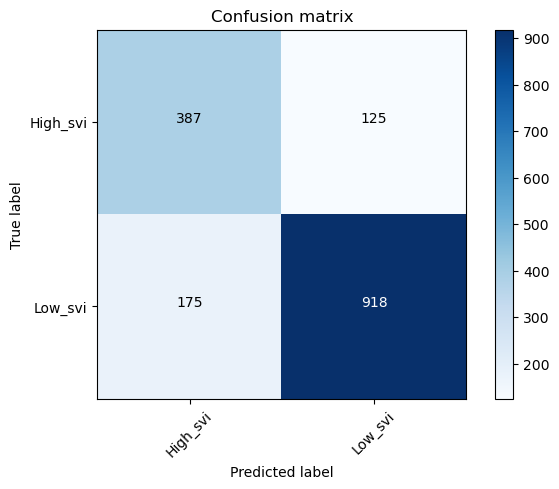

In [488]:
plot_cf_matrix(y_real, y_predict)

In [26]:
#model with resampling

In [309]:
X, Y = km.create_join_x_y_arr(join_list, n_steps_in=7, binary=True)
X_normalize, Y_normalize, scalers = km.normalize(X, Y)
X_normalize = np.nan_to_num(X_normalize, nan=-1)
# X_normalize, Y_normalize = over_sample(X_normalize, Y_normalize)

100%|██████████| 7/7 [00:00<00:00, 45.69it/s]


In [489]:
# samplers_available = [RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE]
samplers = [SMOTE]
results_list = []
for sampler in samplers:
    Xtrain, Xtest, ytrain, ytest = train_test_split(X_normalize, Y_normalize, test_size=0.10, random_state=42)
    Xtrain, ytrain = over_sample(Xtrain, ytrain, sampler)

    model = Sequential()
    model.add(LSTM(units=50, activation='relu', name='first_lstm', recurrent_dropout=0.1, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer='adam', loss='binary_crossentropy', 
                  metrics=[keras.metrics.BinaryAccuracy(name='binary_accuracy', dtype=None, threshold=0.5)])
    model.fit(Xtrain, ytrain, epochs=6, batch_size=10, shuffle=True)

    Yhat, Ytest = km.evaluate(model, Xtest, ytest, scalers, binary=True)
    y_real = Ytest.astype(int)
    threshold = threshold_for_max_f1(y_real, Yhat)
    y_predict = np.where(Yhat > threshold, 1, 0).astype(int)
    
    print(km.results(y_real, y_predict))
    results_list.append(km.results(y_real, y_predict))
    

Epoch 1/6
19564/19564 [==============================] - 18s 939us/step - loss: 0.5955 - binary_accuracy: 0.5879
Epoch 2/6
19564/19564 [==============================] - 17s 856us/step - loss: 0.4640 - binary_accuracy: 0.6923
Epoch 3/6
19564/19564 [==============================] - 17s 889us/step - loss: 0.4405 - binary_accuracy: 0.7297
Epoch 4/6
19564/19564 [==============================] - 17s 881us/step - loss: 0.4295 - binary_accuracy: 0.7482
Epoch 5/6
19564/19564 [==============================] - 17s 889us/step - loss: 0.4199 - binary_accuracy: 0.7590
Epoch 6/6
19564/19564 [==============================] - 17s 881us/step - loss: 0.4117 - binary_accuracy: 0.7666
(0.8249221183800624, 0.71875, 0.7287128712871287, 0.7236971484759096)


In [28]:
Xtrain, Xtest, ytrain, ytest = get_Xtrain_Xtest_ytrain_ytest(7, 1, resample)

samplers = [SMOTE]
results_list = []
for sampler in samplers:
    
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', name='first_lstm', recurrent_dropout=0.1, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer='adam', loss='binary_crossentropy', 
                  metrics=[keras.metrics.BinaryAccuracy(name='binary_accuracy', dtype=None, threshold=0.5)])
    model.fit(Xtrain, ytrain, epochs=6, batch_size=10, shuffle=True)

    Yhat, Ytest = km.evaluate(model, Xtest, ytest, scalers, binary=True)
    y_real = Ytest.astype(int)
    threshold = threshold_for_max_f1(y_real, Yhat)
    y_predict = np.where(Yhat > threshold, 1, 0).astype(int)
    
    print(km.results(y_real, y_predict))
    results_list.append(km.results(y_real, y_predict))

    

100%|██████████| 7/7 [00:00<00:00, 492.12it/s]


Epoch 1/6
17400/17400 [==============================] - 17s 957us/step - loss: 0.4987 - binary_accuracy: 0.7033
Epoch 2/6
17400/17400 [==============================] - 16s 902us/step - loss: 0.4352 - binary_accuracy: 0.7614
Epoch 3/6
17400/17400 [==============================] - 16s 935us/step - loss: 0.4125 - binary_accuracy: 0.7776
Epoch 4/6
17400/17400 [==============================] - 14s 827us/step - loss: 0.4069 - binary_accuracy: 0.7858
Epoch 5/6
17400/17400 [==============================] - 14s 831us/step - loss: 0.4045 - binary_accuracy: 0.7908
Epoch 6/6
17400/17400 [==============================] - 15s 877us/step - loss: 0.3999 - binary_accuracy: 0.7944
(0.824555936428794, 0.7611218568665378, 0.71350861287398, 0.7365465605989705)


results: (0.824555936428794, 0.7611218568665378, 0.71350861287398, 0.7365465605989705) 

Confusion matrix, without normalization
[[ 787  247]
 [ 316 1859]]


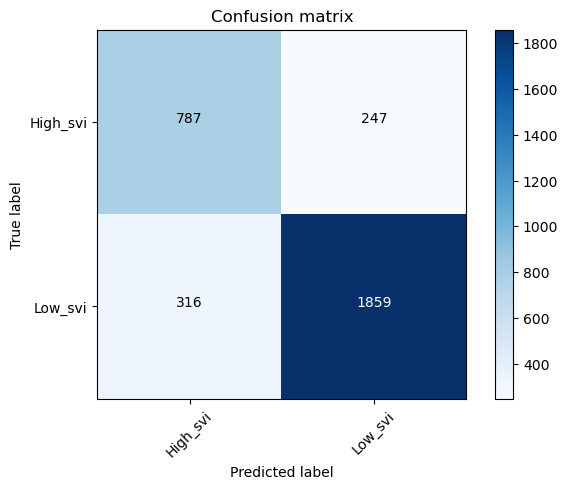

In [29]:
plot_cf_matrix(y_real, y_predict)

In [ ]:
res = []

In [134]:
def results_from_training_model(j = 50, k = 25, l = 4, m = 10, resample = SMOTE, recurrent_dropout = 0.1, threshold = 0.85, epochs = 6, batch_size = 10):
    Xtrain, Xtest, ytrain, ytest, scalers = get_Xtrain_Xtest_ytrain_ytest_scalers(7, 1, resample)

    model = Sequential()
    model.add(LSTM(units=j, activation='relu', name='first_lstm', recurrent_dropout=recurrent_dropout, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
    model.add(Dense(k, activation='relu'))
    model.add(Dense(m, activation='relu'))
    model.add(Dense(l, activation='relu'))
    model.add(Dense(1, activation="sigmoid"))

    model.compile(optimizer='adam', loss='binary_crossentropy', 
                  metrics=[keras.metrics.BinaryAccuracy(name='binary_accuracy', dtype=None, threshold=threshold)])
    model.fit(Xtrain, ytrain, epochs=epochs, batch_size=batch_size, shuffle=True)

    
    X_fit_threshold, Xtest, y_fit_threshold, ytest = train_test_split(Xtest, ytest, test_size=0.67, random_state=42)
    Yhat, Ytest = km.evaluate(model, X_fit_threshold, y_fit_threshold, scalers, binary=True)
    y_real = Ytest.astype(int)
    threshold = threshold_for_max_f1(y_real, Yhat)
    y_predict = np.where(Yhat > threshold, 1, 0).astype(int)
    
    Yhat, Ytest = km.evaluate(model, Xtest, ytest, scalers, binary=True)
    y_real = Ytest.astype(int)
#     threshold = threshold_for_max_f1(y_real, Yhat)
    y_predict = np.where(Yhat > threshold, 1, 0).astype(int)
        
    return km.results(y_real, y_predict)

# res.append(results_from_training_model(epochs = 6, l = 5))
# res.append(results_from_training_model(epochs = 6, l = 6))
# res.append(results_from_training_model(epochs = 6, l = 6, m = 12))
# res.append(results_from_training_model(epochs = 6, l = 5, m = 11))
# res.append(results_from_training_model(epochs = 6, l = 5, m = 9))
# res.append(results_from_training_model(epochs = 6, l = 4))
# res.append(results_from_training_model(epochs = 6, k = 24))
# res.append(results_from_training_model(epochs = 6, k = 26))
# res.append(results_from_training_model(epochs = 6, k = 30))
# res.append(results_from_training_model(epochs = 6, k = 28))
# res.append(results_from_training_model(epochs = 6, k = 27))
# res.append(results_from_training_model(epochs = 6, k = 26))
res.append(results_from_training_model(epochs = 6, k = 25))
res.append(results_from_training_model(epochs = 6, k = 26))

# res.append(results_from_training_model(epochs = 6, l = 6, m = 12))

[x[3] for x in res]

100%|██████████| 7/7 [00:00<00:00, 460.38it/s]


Epoch 1/6
15280/15280 [==============================] - 17s 1ms/step - loss: 0.5648 - binary_accuracy: 0.4962
Epoch 2/6
15280/15280 [==============================] - 14s 898us/step - loss: 0.4732 - binary_accuracy: 0.4994
Epoch 3/6
15280/15280 [==============================] - 14s 906us/step - loss: 0.4393 - binary_accuracy: 0.4999
Epoch 4/6
15280/15280 [==============================] - 14s 909us/step - loss: 0.4242 - binary_accuracy: 0.5112
Epoch 5/6
15280/15280 [==============================] - 14s 931us/step - loss: 0.4176 - binary_accuracy: 0.5544
Epoch 6/6
15280/15280 [==============================] - 15s 960us/step - loss: 0.4110 - binary_accuracy: 0.5862


100%|██████████| 7/7 [00:00<00:00, 470.51it/s]


Epoch 1/6
15280/15280 [==============================] - 16s 1ms/step - loss: 0.5062 - binary_accuracy: 0.5414
Epoch 2/6
15280/15280 [==============================] - 15s 1ms/step - loss: 0.4285 - binary_accuracy: 0.6266
Epoch 3/6
15280/15280 [==============================] - 12s 810us/step - loss: 0.4149 - binary_accuracy: 0.6601
Epoch 4/6
15280/15280 [==============================] - 14s 896us/step - loss: 0.4094 - binary_accuracy: 0.6781
Epoch 5/6
15280/15280 [==============================] - 13s 849us/step - loss: 0.4047 - binary_accuracy: 0.6895
Epoch 6/6
15280/15280 [==============================] - 13s 848us/step - loss: 0.4050 - binary_accuracy: 0.6969


[0.7454965357967668,
 0.7390134529147983,
 0.7395588925387141,
 0.7429864253393665,
 0.7379830348727616,
 0.7428311333636778,
 0.7444933920704845,
 0.7497700091996321,
 0.7411873840445269,
 0.7378277153558052,
 0.7330716388616291,
 0.7393617021276595,
 0.7375820056232427,
 0.7467149977344811]

In [99]:
results_list

[(0.8302180685358256,
  0.7155963302752294,
  0.7684729064039408,
  0.7410926365795724)]

In [88]:
results_list #50, 100, units, 0.85 threshold, 10 batch size, 1/5 train data

[(0.8255451713395638,
  0.7339449541284404,
  0.7476635514018691,
  0.7407407407407407)]

In [84]:
results_list #50, 100, units, 0.85 threshold, 10 batch size, 1/5 data, 0.2 train data, 0.8 test data

[(0.7963395638629284,
  0.749112426035503,
  0.6705508474576272,
  0.7076579094466181)]

In [81]:
results_list #50, 100, units, 0.85 threshold, 10 batch size, 0.2 train data, 0.8 test data

[(0.8127921470863197,
  0.7559912854030502,
  0.6912350597609562,
  0.7221644120707597)]

In [76]:
results_list #50, 100, units, 0.85 threshold, 10 batch size, 1/5 train data

[(0.8193146417445483,
  0.8165137614678899,
  0.7007874015748031,
  0.7542372881355932)]

In [74]:
results_list #50, 100, units, 0.85 threshold, 10 batch size, 1/5 train data

[(0.8084112149532711,
  0.8532110091743119,
  0.6714801444043321,
  0.7515151515151515)]

In [71]:
results_list #50, 100, units, 0.85 threshold, 10 batch size

[(0.8279837955749455,
  0.7794970986460348,
  0.7132743362831858,
  0.744916820702403)]

In [69]:
results_list #50, 100, units, 0.85 threshold, 12 batch size

[(0.8270489248987224,
  0.7611218568665378,
  0.7187214611872146,
  0.7393142320338186)]

In [67]:
results_list #50, 100, units, 0.85 threshold, 8 batch size

[(0.8254908071050171,
  0.776595744680851,
  0.7093639575971732,
  0.7414589104339797)]

In [65]:
results_list #50, 100, units, 0.90 threshold, 10 batch size

[(0.8335930196322842,
  0.7495164410058027,
  0.7380952380952381,
  0.7437619961612283)]

In [63]:
results_list #70, 140, units, 0.80 threshold

[(0.8304767840448738,
  0.7717601547388782,
  0.7215189873417721,
  0.7457943925233645)]

In [58]:
results_list #50, 100, units, 0.80 threshold

[(0.8335930196322842,
  0.7591876208897486,
  0.7336448598130841,
  0.7461977186311788)]

In [56]:
results_list #30, 60, units, 0.80 threshold

[(0.8295419133686507,
  0.7669245647969052,
  0.721565059144677,
  0.743553680262541)]

In [54]:
results_list #25, 50, units, 0.80 threshold

[(0.8264256777812402,
  0.7620889748549323,
  0.7170154686078253,
  0.7388654477262073)]

In [52]:
results_list

[(0.8292302898099096,
  0.7649903288201161,
  0.7217153284671532,
  0.7427230046948358)]

In [50]:
results_list

[(0.8261140542224992,
  0.7688588007736944,
  0.7136445242369839,
  0.740223463687151)]

In [48]:
results_list

[(0.832034901838579,
  0.7591876208897486,
  0.7302325581395349,
  0.7444286391654814)]

In [46]:
results_list

[(0.8298535369273917,
  0.746615087040619,
  0.7310606060606061,
  0.738755980861244),
 (0.8311000311623559, 0.7330754352030948, 0.740234375, 0.7366375121477163),
 (0.8301651604861328,
  0.7591876208897486,
  0.7261794634597595,
  0.7423167848699764)]

In [44]:
results_list

[(0.8357743845434715,
  0.7359767891682786,
  0.7497536945812808,
  0.7428013665202539),
 (0.8289186662511686,
  0.741779497098646,
  0.7311725452812202,
  0.7364378300528085),
 (0.8295419133686507,
  0.7727272727272727,
  0.7191719171917191,
  0.744988344988345)]

In [42]:
results_list

[(0.8345278903085073,
  0.7427466150870407,
  0.7434656340755083,
  0.7431059506531205),
 (0.8239326893113119,
  0.776595744680851,
  0.7062445030782761,
  0.7397512666973745),
 (0.8329697725148021,
  0.7620889748549323,
  0.7309833024118738,
  0.7462121212121211)]

In [40]:
results_list

[(0.8236210657525709,
  0.769825918762089,
  0.708185053380783,
  0.7377201112140872),
 (0.824244312870053,
  0.7727272727272727,
  0.7083333333333334,
  0.7391304347826088),
 (0.8261140542224992,
  0.7736943907156673,
  0.7117437722419929,
  0.7414272474513439)]

In [36]:
[x[3] for x in results_list]

[0.7083912841910058,
 0.7344632768361582,
 0.7445678416224047,
 0.7457627118644068,
 0.7456479690522245,
 0.7445394112060778]

results: (0.3222187597382362, 1.0, 0.3222187597382362, 0.4873909969361301) 

Confusion matrix, without normalization
[[1034    0]
 [2175    0]]


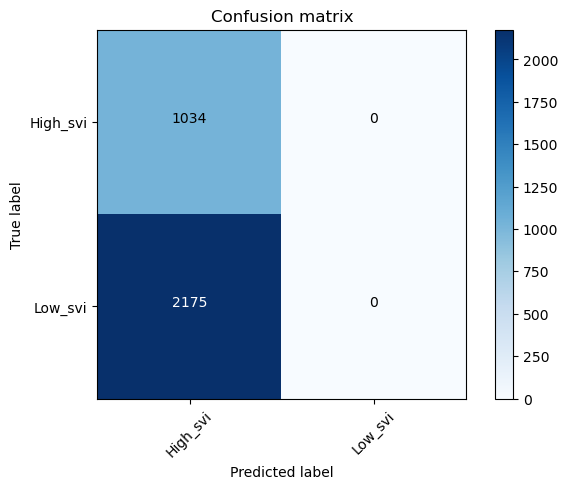

In [38]:
plot_cf_matrix(y_real, y_predict)

results: (0.8008725459644749, 0.741779497098646, 0.6733977172958736, 0.7059364933271974) 

Confusion matrix, without normalization
[[ 767  267]
 [ 372 1803]]


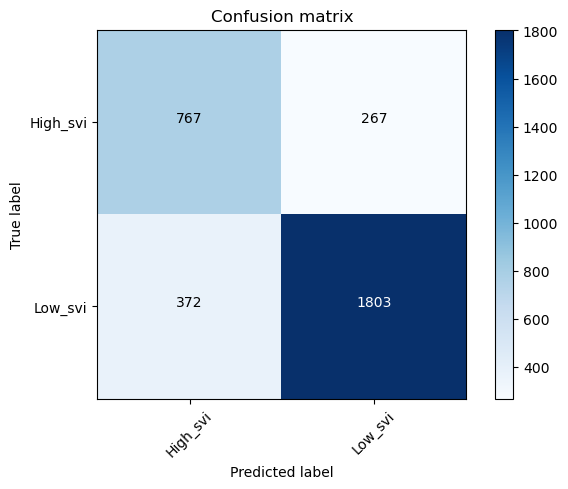

In [25]:
plot_cf_matrix(y_real, y_predict)

In [ ]:
#extra metrics

In [505]:
# fpr, tpr, thresholds = roc_curve(Ytest, Yhat)

In [506]:
# auc(fpr, tpr)

0.8837595779963403

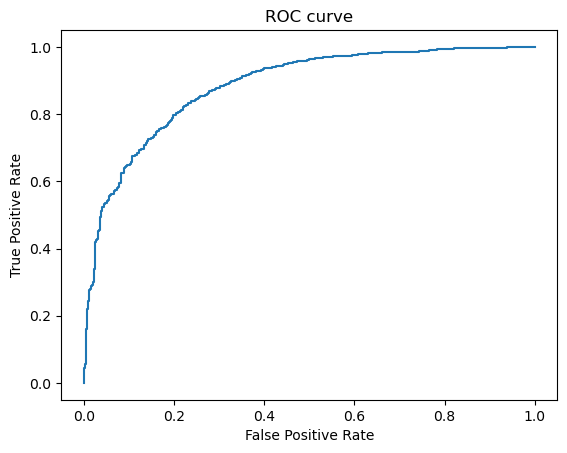

In [507]:
# plt.plot(fpr, tpr)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC curve')
# plt.show()

In [ ]:
#general model training architecture

In [18]:
model_names = {1: 'Simple LSTM',
               2: 'Stacked LSTM',
               3: 'Bidirectional LSTM',
               4: 'CNN',
               5: 'CNN LSTM',
               6: 'LSTM Autoencoder',
               7: 'Deep CNN',
               8: 'GRU',
               9: 'GRU CNN'}

def plot_graphs_metrics(model, results_list, steps_in, steps_out):
    model_name = model_names[model]
    
    #this block of code is because some models (like 6) require steps_in start at 3 instead of 1
    shift_vals = {1: 1,
                  3: 1,
                  6: 3,
                  9: 2}
    shift_val = shift_vals[model]
    
    #plot graph of a metric result for all n_step_in and n_step_out values
    x=list(range(1, steps_out))
    label = ['accuracy', 'TNR', 'NPV', 'f1']
    for z in range(4):
        for i in range(steps_in-shift_val):
            y=[]
            for j in range(steps_out-1):
                y.append(results_list[i*(steps_out-1):i*(steps_out-1) + (steps_out-1)][j][z])
            plt.plot(x, y, label=f'n_steps_in={i+shift_val}')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.xlabel("n_steps_out")
        plt.ylabel(label[z])
        plt.title(model_name + ", 3 layers (50,25,1),\n name='first_lstm', recurrent_dropout=0.1 \n optimizer='adam', loss='binary_crossentropy' ")
        plt.savefig(f"figures/{model_name} {label[z]}.png", bbox_inches="tight")
        plt.close()    
    
    #plot graph of all metric results for a n_step_in value
    x=list(range(1, steps_out))
    label = ['accuracy', 'TNR', 'NPV', 'f1']
    for z in range(steps_in-shift_val):
        for i in range(4):
            y=[]
            for j in range(steps_out-1):
                y.append(results_list[z*(steps_out-1):z*(steps_out-1)+(steps_out-1)][j][i])
            plt.plot(x, y, label=label[i])
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.xlabel("n_steps_out")
        plt.ylabel('Metric value')
        plt.title(f"{model_name}, 3 layers (50,25,1),\n name='first_lstm', recurrent_dropout=0.1 \n optimizer='adam', loss='binary_crossentropy' \n n_steps_in={z+shift_val} ")
        plt.savefig(f"figures/{model_name} n_steps_in={z+shift_val}.png", bbox_inches="tight")
        plt.close()

In [118]:
#Helper functions
def get_Xtrain_Xtest_ytrain_ytest_scalers(i, j, resample):
    '''
    Returns (Xtrain, Xtest, ytrain, ytest) based on number of steps in, number of steps out,
    and the parameter specifying which resampler we're using (or None).
    '''
    X, Y = km.create_join_x_y_arr(reactor_list, n_steps_in=i, n_steps_out = j, binary=True)
    X_normalize, Y_normalize, scalers = km.normalize(X, Y)
    X_normalize = np.nan_to_num(X_normalize, nan=-1)
    ### reduces size of dataset to test size (=0.2 rn)
#     Xtrash, X_normalize, Ytrash, Y_normalize = train_test_split(X_normalize, Y_normalize, test_size=0.20, random_state=42)
    ### reduces size of dataset
    Xtrain, Xtest, ytrain, ytest = train_test_split(X_normalize, Y_normalize, test_size=0.30, random_state=42)
    
    if resample != None:
        Xtrain, ytrain = over_sample(Xtrain, ytrain, resample)
    return Xtrain, Xtest, ytrain, ytest, scalers


#Model type 1
def train_SIMPLE_LSTM_model(epochs, steps_in, steps_out, resample):
    results_list = []
    for i in tqdm(range(7, steps_in)):
        for j in tqdm(range(1, steps_out)):
            Xtrain, Xtest, ytrain, ytest, scalers = get_Xtrain_Xtest_ytrain_ytest_scalers(i, j, resample)
            
            features = Xtrain.shape[2]
            model = Sequential()
            model.add(LSTM(units=50, activation='relu', name='first_lstm', recurrent_dropout=0.1, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
            model.add(Dense(25, activation='relu'))
            model.add(Dense(1, activation="sigmoid"))
            
            model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy')
#             model.compile(optimizer='adam', loss='binary_crossentropy', 
#                   metrics=[keras.metrics.BinaryAccuracy(name='binary_accuracy', dtype=None, threshold=0.5)])
    
            model.fit(Xtrain, ytrain, epochs=epochs, batch_size=10, shuffle=True)
            
            Yhat, Ytest = km.evaluate(model, Xtest, ytest, scalers, binary=True)
            y_real = Ytest.astype(int)
            threshold = threshold_for_max_f1(y_real, Yhat)
            y_predict = np.where(Yhat > threshold, 1, 0).astype(int)
            results_list.append(km.results(y_real, y_predict))
            print('inputs', (epochs, steps_in, steps_out), 'outputs', km.results(y_real, y_predict))
                  
    return results_list

#Model type 3
def train_BIDIRECTIONAL_LSTM_model(epochs, steps_in, steps_out, resample):
    results_list = []
    for i in range(1, steps_in):
        for j in range(1, steps_out):
            Xtrain, Xtest, ytrain, ytest = get_Xtrain_Xtest_ytrain_ytest_scalers(i, j, resample)
            
            features = Xtrain.shape[2]
            model = Sequential()
            model.add(Bidirectional(LSTM(100, return_sequences=True, activation='relu')))
            model.add(Bidirectional(LSTM(50, return_sequences=True, activation='relu')))
            model.add(Bidirectional(LSTM(20, activation='relu')))
            model.add(Dense(1, activation="sigmoid"))
            
            model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy')
            model.fit(Xtrain, ytrain, epochs=epochs, batch_size=10, shuffle=True)
            
            Yhat, Ytest = km.evaluate(model, Xtest, ytest, scalers, binary=True)
            y_real = Ytest.astype(int)
            threshold = threshold_for_max_f1(y_real, Yhat)
            y_predict = np.where(Yhat > threshold, 1, 0).astype(int)
            results_list.append(km.results(y_real, y_predict))
    return results_list

#Model type 6
#For some reason we need steps_in to be at least 3 for this one
#This probably has to do with the pooling, Convolution, or Dropout layers
def train_LSTM_AUTOENCODER_model(epochs, steps_in, steps_out, resample):
    results_list = []
    for i in range(3, steps_in):
        for j in range(1, steps_out):
            Xtrain, Xtest, ytrain, ytest = get_Xtrain_Xtest_ytrain_ytest_scalers(i, j, resample)
            
            features = Xtrain.shape[2]
            model = Sequential()
            model.add(Conv1D(filters=128, 
                             kernel_size=2, 
                             activation='relu', 
                             name='extractor', 
                             input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
            model.add(Dropout(0.3))
            model.add(MaxPooling1D(pool_size=2))
            model.add(Bidirectional(LSTM(50, activation='relu', input_shape=(Xtrain.shape[1], Xtrain.shape[2]))))
            model.add(RepeatVector(10))
            model.add(Bidirectional(LSTM(50, activation='relu')))
            model.add(Dense(1))

            model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy')
            model.fit(Xtrain, ytrain, epochs=epochs, batch_size=10, shuffle=True)
            
            Yhat, Ytest = km.evaluate(model, Xtest, ytest, scalers, binary=True)
            y_real = Ytest.astype(int)
            threshold = threshold_for_max_f1(y_real, Yhat)
            y_predict = np.where(Yhat > threshold, 1, 0).astype(int)
            results_list.append(km.results(y_real, y_predict))
    return results_list

#Model type 9
#steps_in must be at least 2 for this one.
def train_GRU_CNN_model(epochs, steps_in, steps_out, resample):
    results_list = []
    for i in range(2, steps_in):
        for j in range(1, steps_out):
            Xtrain, Xtest, ytrain, ytest = get_Xtrain_Xtest_ytrain_ytest_scalers(i, j, resample)
            
            features = Xtrain.shape[2]
            inp_seq = Input(shape=(Xtrain.shape[1], Xtrain.shape[2]))
            x = Bidirectional(GRU(100, return_sequences=True))(inp_seq)
            x = AveragePooling1D(2)(x)
            x = Conv1D(100, 3, activation='relu', padding='same',
                       name='extractor')(x)
            x = Flatten()(x)
            x = Dense(16, activation='relu')(x)
            x = Dropout(0.5)(x)

            out = Dense(1, activation="sigmoid")(x)

            model = Model(inp_seq, out)

            
            model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy')
            model.fit(Xtrain, ytrain, epochs=epochs, batch_size=10, shuffle=True)
            
            Yhat, Ytest = km.evaluate(model, Xtest, ytest, scalers, binary=True)
            y_real = Ytest.astype(int)
            threshold = threshold_for_max_f1(y_real, Yhat)
            y_predict = np.where(Yhat > threshold, 1, 0).astype(int)
            results_list.append(km.results(y_real, y_predict))
    return results_list

In [33]:
#Code to run models
list_of_result_lists = {}
models_list = [1]

epochs = 6
steps_in = 7
steps_out = 1
resample = SMOTE

steps_in += 1
steps_out += 1

for m in models_list:
    if m == 1:
        results_list = train_SIMPLE_LSTM_model(epochs, steps_in, steps_out, resample)
    elif m == 3:
        results_list = train_BIDIRECTIONAL_LSTM_model(epochs, steps_in, steps_out, resample)
    elif m == 6:
        results_list = train_LSTM_AUTOENCODER_model(epochs, steps_in, steps_out, resample)
    elif m == 9:
        results_list = train_GRU_CNN_model(epochs, steps_in, steps_out, resample)
    
    list_of_result_lists[m] = results_list
    plot_graphs_metrics(m, results_list, steps_in, steps_out)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:00<00:00, 333.95it/s]


Epoch 1/6
17400/17400 [==============================] - 17s 976us/step - loss: 0.5155
Epoch 2/6
17400/17400 [==============================] - 14s 811us/step - loss: 0.4524
Epoch 3/6
17400/17400 [==============================] - 16s 915us/step - loss: 0.4325
Epoch 4/6
17400/17400 [==============================] - 15s 841us/step - loss: 0.4190
Epoch 5/6
17400/17400 [==============================] - 15s 865us/step - loss: 0.4120
Epoch 6/6
17400/17400 [==============================] - 14s 808us/step - loss: 0.4074



100%|██████████| 1/1 [01:33<00:00, 93.72s/it]

inputs (6, 8, 2) outputs (0.8236210657525709, 0.7707930367504836, 0.7078152753108348, 0.7379629629629629)


IndexError: list index out of range

In [ ]:
results_list

In [517]:
results_list

[(0.7181082762912259,
  0.8696461824953445,
  0.5494117647058824,
  0.6733958183129056)]

In [ ]:
list_of_result_lists

In [ ]:
# list_of_result_lists[6]